# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
# import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-08 14:05 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-08 14:05 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-08 14:05 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-08 14:05 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-08 14:05 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-08 14:05 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-08 14:05 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-08 14:05 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-08 14:05 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [5]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [6]:
# Прочитаем данные, сразу получив RDD
ratings = sc.textFile(RATINGS_PATH)

In [7]:
%%time
ratings.take(5)

CPU times: user 8.77 ms, sys: 6.08 ms, total: 14.9 ms
Wall time: 4.7 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [8]:
ratings.getNumPartitions()

5

In [9]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [10]:
type(ratings)

pyspark.rdd.PipelinedRDD

In [11]:
ratings.count()

25000095

Количество пользователей

In [12]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 35.3 ms, sys: 20.6 ms, total: 55.9 ms
Wall time: 1min 25s


162541

Сохраним датасет в память

In [13]:
# ratings = ratings.persist()

In [14]:
# %%time

# ratings \
#     .map(lambda r: r.user_id)\
#     .distinct()\
#     .count()

Количество фильмов

In [13]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 34.5 ms, sys: 13.3 ms, total: 47.8 ms
Wall time: 1min 28s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [14]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [15]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196631, (5.0, ['196631', 'Red Is the Color of (2007)'])),
 (131188, (5.0, ['131188', 'A Man To Remember (1938)'])),
 (207642, (5.0, ['207642', 'Kabir Singh (2019)'])),
 (164620, (5.0, ['164620', 'Zig Zag Story (1983)'])),
 (148254, (5.0, ['148254', 'A Dark Place Inside'])),
 (181175, (5.0, ['181175', 'War Requiem (1989)'])),
 (115795, (5.0, ['115795', 'Bronx Obama (2014)'])),
 (83161, (5.0, ['83161', 'Deadly Delicious (Shuang Shi Ji) (2008)'])),
 (185893, (5.0, ['185893', 'The Fox in the Chicken Coop (1978)'])),
 (165285, (5.0, ['165285', 'Homeless for the Holidays (2009)']))]

In [16]:
movies.take(10)

[(1, ['1', 'Toy Story (1995)']),
 (2, ['2', 'Jumanji (1995)']),
 (3, ['3', 'Grumpier Old Men (1995)']),
 (4, ['4', 'Waiting to Exhale (1995)']),
 (5, ['5', 'Father of the Bride Part II (1995)']),
 (6, ['6', 'Heat (1995)']),
 (7, ['7', 'Sabrina (1995)']),
 (8, ['8', 'Tom and Huck (1995)']),
 (9, ['9', 'Sudden Death (1995)']),
 (10, ['10', 'GoldenEye (1995)'])]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [17]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [18]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-08 14:13 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58976 2021-02-08 14:13 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112528 2021-02-08 14:13 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131435 2021-02-08 14:13 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114337 2021-02-08 14:13 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133615 2021-02-08 14:13 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117755 2021-02-08 14:13 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     142933 2021-02-08 14:13 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132298 2021-02-08 14:13 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167627 2021-02-08 14:13 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [19]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [20]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [21]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

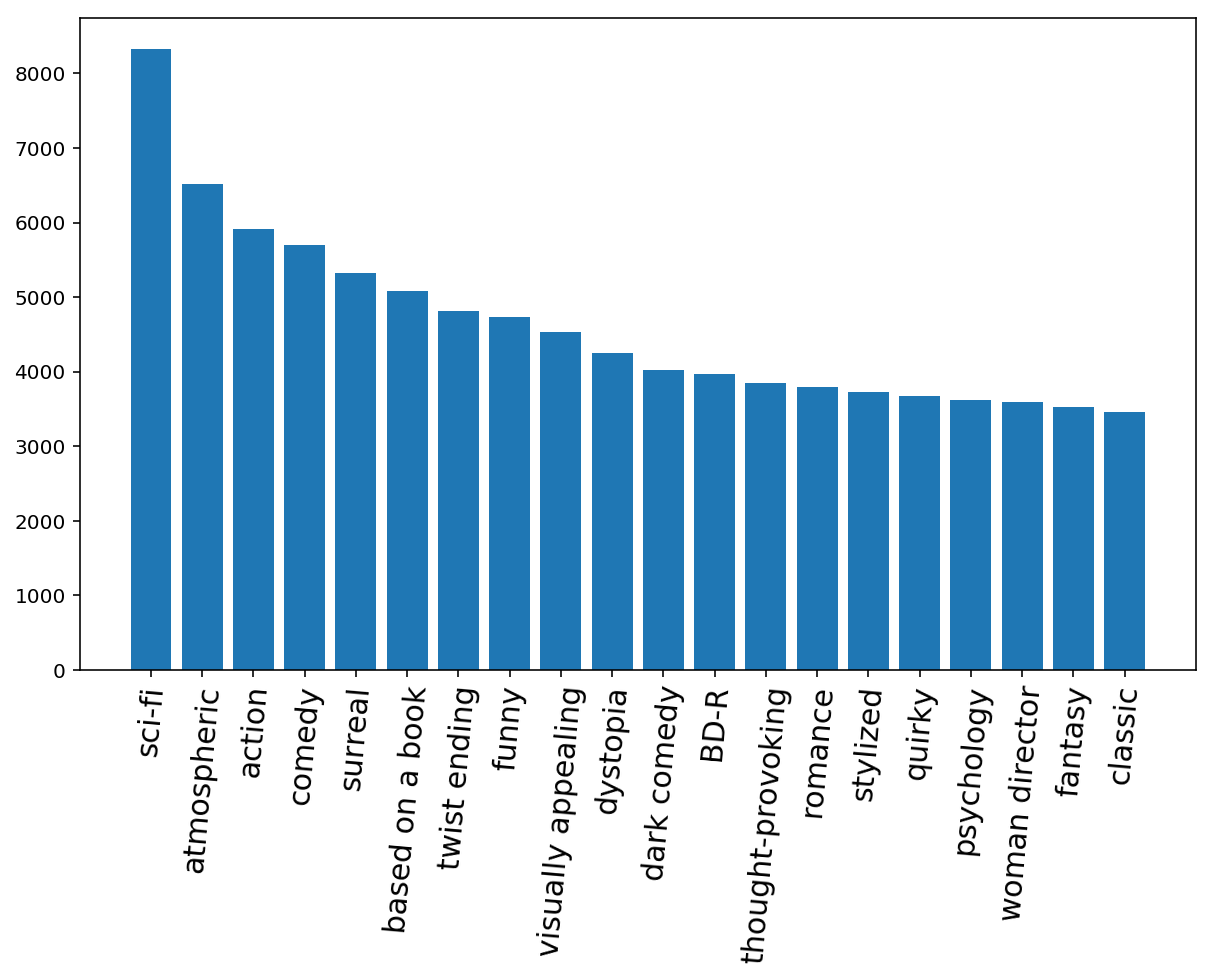

In [22]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [23]:
movies.take(5)

[(1, ['1', 'Toy Story (1995)']),
 (2, ['2', 'Jumanji (1995)']),
 (3, ['3', 'Grumpier Old Men (1995)']),
 (4, ['4', 'Waiting to Exhale (1995)']),
 (5, ['5', 'Father of the Bride Part II (1995)'])]

In [24]:
marks_count = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .join(movies)

# marks_number.take(5)

In [25]:
marks_count =  marks_count \
    .map(lambda s: (s[1][1][1], s[1][0])) \
    .sortBy(lambda key_value: key_value[1], ascending=False) \
    .take(10)

marks_count

[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [26]:
marks5_count = ratings \
    .filter(lambda data: data.rating == 5)\
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .join(movies)

marks5_count =  marks5_count \
    .map(lambda s: (s[1][1][1], s[1][0])) \
    .sortBy(lambda key_value: key_value[1], ascending=False) \
    .take(10)

marks5_count

[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [27]:
movie_avg_rating.take(5)

[(32770, 3.5727272727272728),
 (5, 3.0584343520573674),
 (196615, 3.5),
 (131080, 3.0),
 (10, 3.42145763311516)]

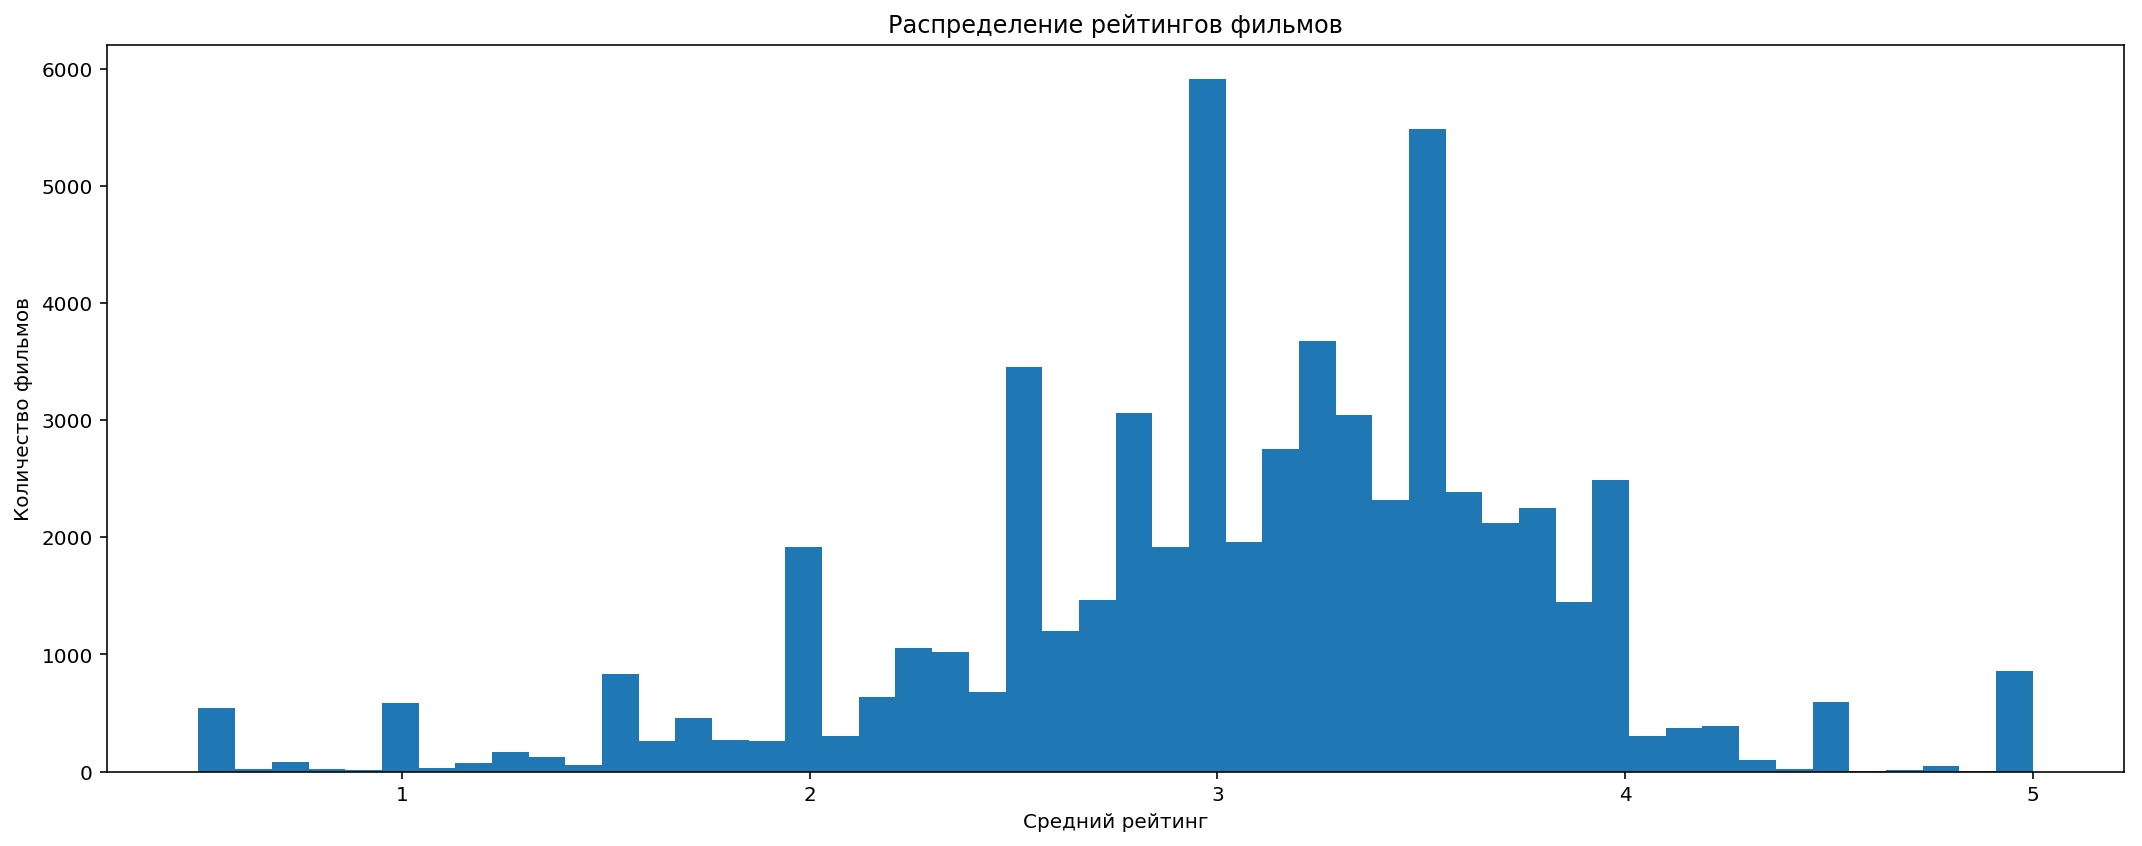

In [28]:
data_avg = movie_avg_rating \
    .map(lambda key_value: key_value[1]) \
    .collect()

f, ax = plt.subplots(figsize=(15, 6))
plt.hist(data_avg, bins=50)
plt.title('Распределение рейтингов фильмов')
plt.xlabel('Средний рейтинг')
plt.ylabel('Количество фильмов')
plt.tight_layout()
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

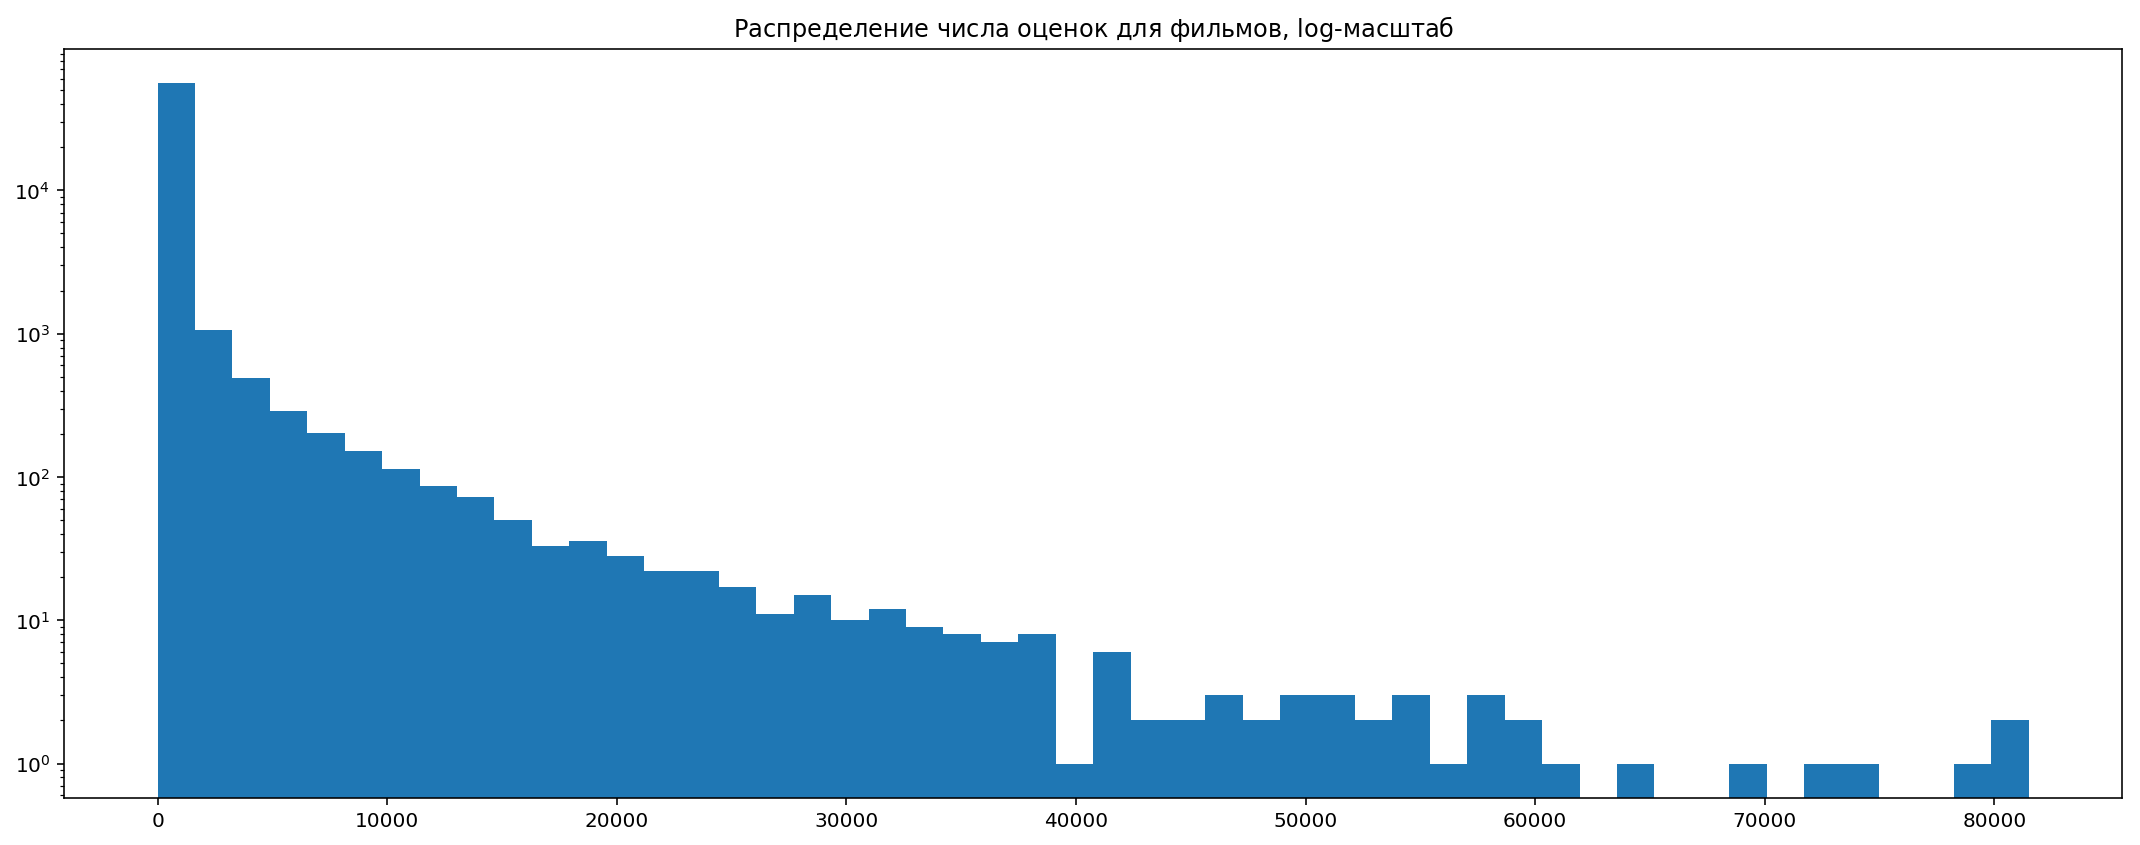

In [29]:
marks_count = ratings \
    .map(lambda temp: (temp.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .map(lambda temp: temp[1]) \
    .collect()

f, ax = plt.subplots(figsize=(15, 6))
plt.hist(marks_count, bins=50, log=True)
plt.title('Распределение числа оценок для фильмов, $\log$-масштаб')
plt.tight_layout()
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [78]:
genres = sc.textFile(MOVIES_PATH) 
genres.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [79]:
genres = genres \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: arr[-1]) \
    .flatMap(lambda genres: genres.split('|')) \
    .map(lambda genre: (genre, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda temp: temp[1], ascending=False) \
    .collect()

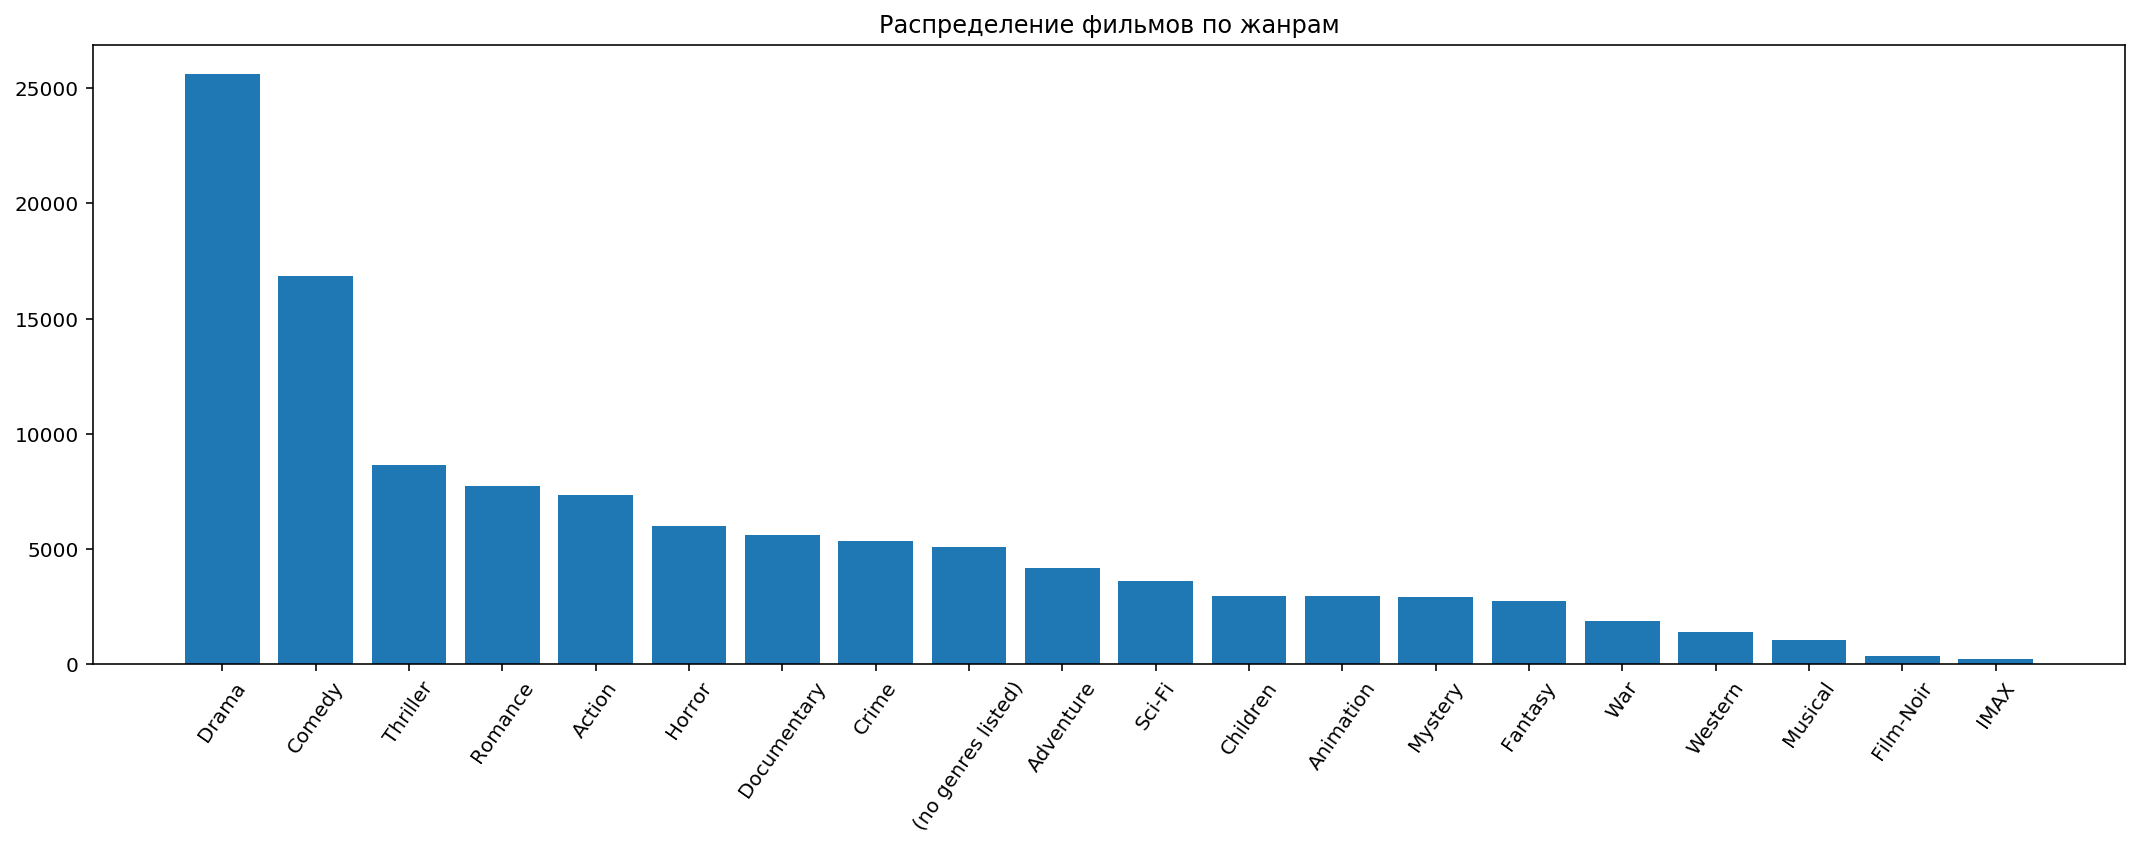

In [80]:
keys, values = zip(*genres)
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation=55, fontsize=10)
plt.bar(keys, values, align="center")
plt.title('Распределение фильмов по жанрам')
plt.tight_layout()
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [33]:
import json

In [34]:
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

In [35]:
links = sc.textFile(LINKS_PATH)
links.take(5)

['movieId,imdbId,tmdbId',
 '1,0114709,862',
 '2,0113497,8844',
 '3,0113228,15602',
 '4,0114885,31357']

In [36]:
links = links \
    .map(lambda s: s.split(",")) \
    .filter(lambda arr: arr[0].isdigit() and arr[1].isdigit() and arr[2].isdigit()) \
    .map(lambda arr: (int(arr[0]), int(arr[1]), int(arr[2])))

# movieId, imdbId, tmdbId
links.take(5)

[(1, 114709, 862),
 (2, 113497, 8844),
 (3, 113228, 15602),
 (4, 114885, 31357),
 (5, 113041, 11862)]

In [37]:
tmdb_to_id = links.map(lambda s: (s[2], s[0]))

# tmdbId, movieId
tmdb_to_id.take(5)

[(862, 1), (8844, 2), (15602, 3), (31357, 4), (11862, 5)]

In [38]:
tmdb = sc.textFile(TMDB_PATH)
tmdb = tmdb.map(lambda s: json.loads(s))
tmdb.take(1)

[{'adult': False,
  'backdrop_path': '/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg',
  'belongs_to_collection': {'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg',
   'id': 10194,
   'name': 'Toy Story Collection',
   'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg'},
  'budget': 30000000,
  'casts': {'cast': [{'cast_id': 14,
     'character': 'Woody (voice)',
     'credit_id': '52fe4284c3a36847f8024f95',
     'gender': 2,
     'id': 31,
     'name': 'Tom Hanks',
     'order': 0,
     'profile_path': '/xxPMucou2wRDxLrud8i2D4dsywh.jpg'},
    {'cast_id': 15,
     'character': 'Buzz Lightyear (voice)',
     'credit_id': '52fe4284c3a36847f8024f99',
     'gender': 2,
     'id': 12898,
     'name': 'Tim Allen',
     'order': 1,
     'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'},
    {'cast_id': 16,
     'character': 'Mr. Potato Head (voice)',
     'credit_id': '52fe4284c3a36847f8024f9d',
     'gender': 2,
     'id': 7167,
     'name': 'Don Rickles',
     'order': 2,
     'profile_path': '/h5Bca

In [40]:
tmdb \
    .filter(lambda s: "id" in s) \
    .map(lambda s: (s["id"], s["casts"]["cast"])) \
    .take(1)

[(862,
  [{'cast_id': 14,
    'character': 'Woody (voice)',
    'credit_id': '52fe4284c3a36847f8024f95',
    'gender': 2,
    'id': 31,
    'name': 'Tom Hanks',
    'order': 0,
    'profile_path': '/xxPMucou2wRDxLrud8i2D4dsywh.jpg'},
   {'cast_id': 15,
    'character': 'Buzz Lightyear (voice)',
    'credit_id': '52fe4284c3a36847f8024f99',
    'gender': 2,
    'id': 12898,
    'name': 'Tim Allen',
    'order': 1,
    'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'},
   {'cast_id': 16,
    'character': 'Mr. Potato Head (voice)',
    'credit_id': '52fe4284c3a36847f8024f9d',
    'gender': 2,
    'id': 7167,
    'name': 'Don Rickles',
    'order': 2,
    'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'},
   {'cast_id': 17,
    'character': 'Slinky Dog (voice)',
    'credit_id': '52fe4284c3a36847f8024fa1',
    'gender': 2,
    'id': 12899,
    'name': 'Jim Varney',
    'order': 3,
    'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'},
   {'cast_id': 18,
    'character': 'Rex (voice)',

In [41]:
actors = tmdb \
    .filter(lambda s: "id" in s) \
    .map(lambda s: (s["id"], s["casts"]["cast"])) \
    .join(tmdb_to_id) \
    .flatMap(lambda key_value: [(actor["id"], actor["name"], key_value[1][1]) for actor in key_value[1][0]]) \
    .keyBy(lambda s: s[2]) \
    .join(movies) \
    .map(lambda s: (s[1][0][0], s[1][0][1], s[1][1][1]))

In [45]:
tom_hanks_films = actors \
    .filter(lambda s: s[0] == 31)\
    .map(lambda s: s[2])\
    .collect()

In [46]:
tom_hanks_films

['Sleepless in Seattle (1993)',
 '"\'burbs',
 'Splash (1984)',
 'Every Time We Say Goodbye (1986)',
 'Elvis Has Left the Building (2004)',
 '"League of Their Own',
 '"Celluloid Closet',
 'Captain Phillips (2013)',
 'Toy Story of Terror (2013)',
 'Shooting War (2000)',
 'Killing Lincoln (2013)',
 'Toy Story (1995)',
 'And the Oscar Goes To... (2014)',
 'Bonfire of the Vanities (1990)',
 'Turner & Hooch (1989)',
 '"Simpsons Movie',
 'Larry Crowne (2011)',
 'Toy Story Toons: Small Fry (2011)',
 'Punchline (1988)',
 '"Man with One Red Shoe',
 'Toy Story 3 (2010)',
 'Sully (2016)',
 'Mazes and Monsters (1982)',
 'Magnificent Desolation: Walking on the Moon (2005)',
 'The Post (2017)',
 '"Money Pit',
 "You've Got Mail (1998)",
 'Toy Story 4 (2019)',
 'Radio Flyer (1992)',
 'California Typewriter (2017)',
 'Apollo 13 (1995)',
 '"Pixar Story',
 '"Terminal',
 'Nothing in Common (1986)',
 'Angels & Demons (2009)',
 '"The Mayo Clinic',
 "He Knows You're Alone (a.k.a. Blood Wedding) (1980)",
 '"La

In [47]:
top10_actors = actors \
    .map(lambda temp: (temp[1], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .sortBy(lambda key: key[1], ascending=False)\
    .take(10)

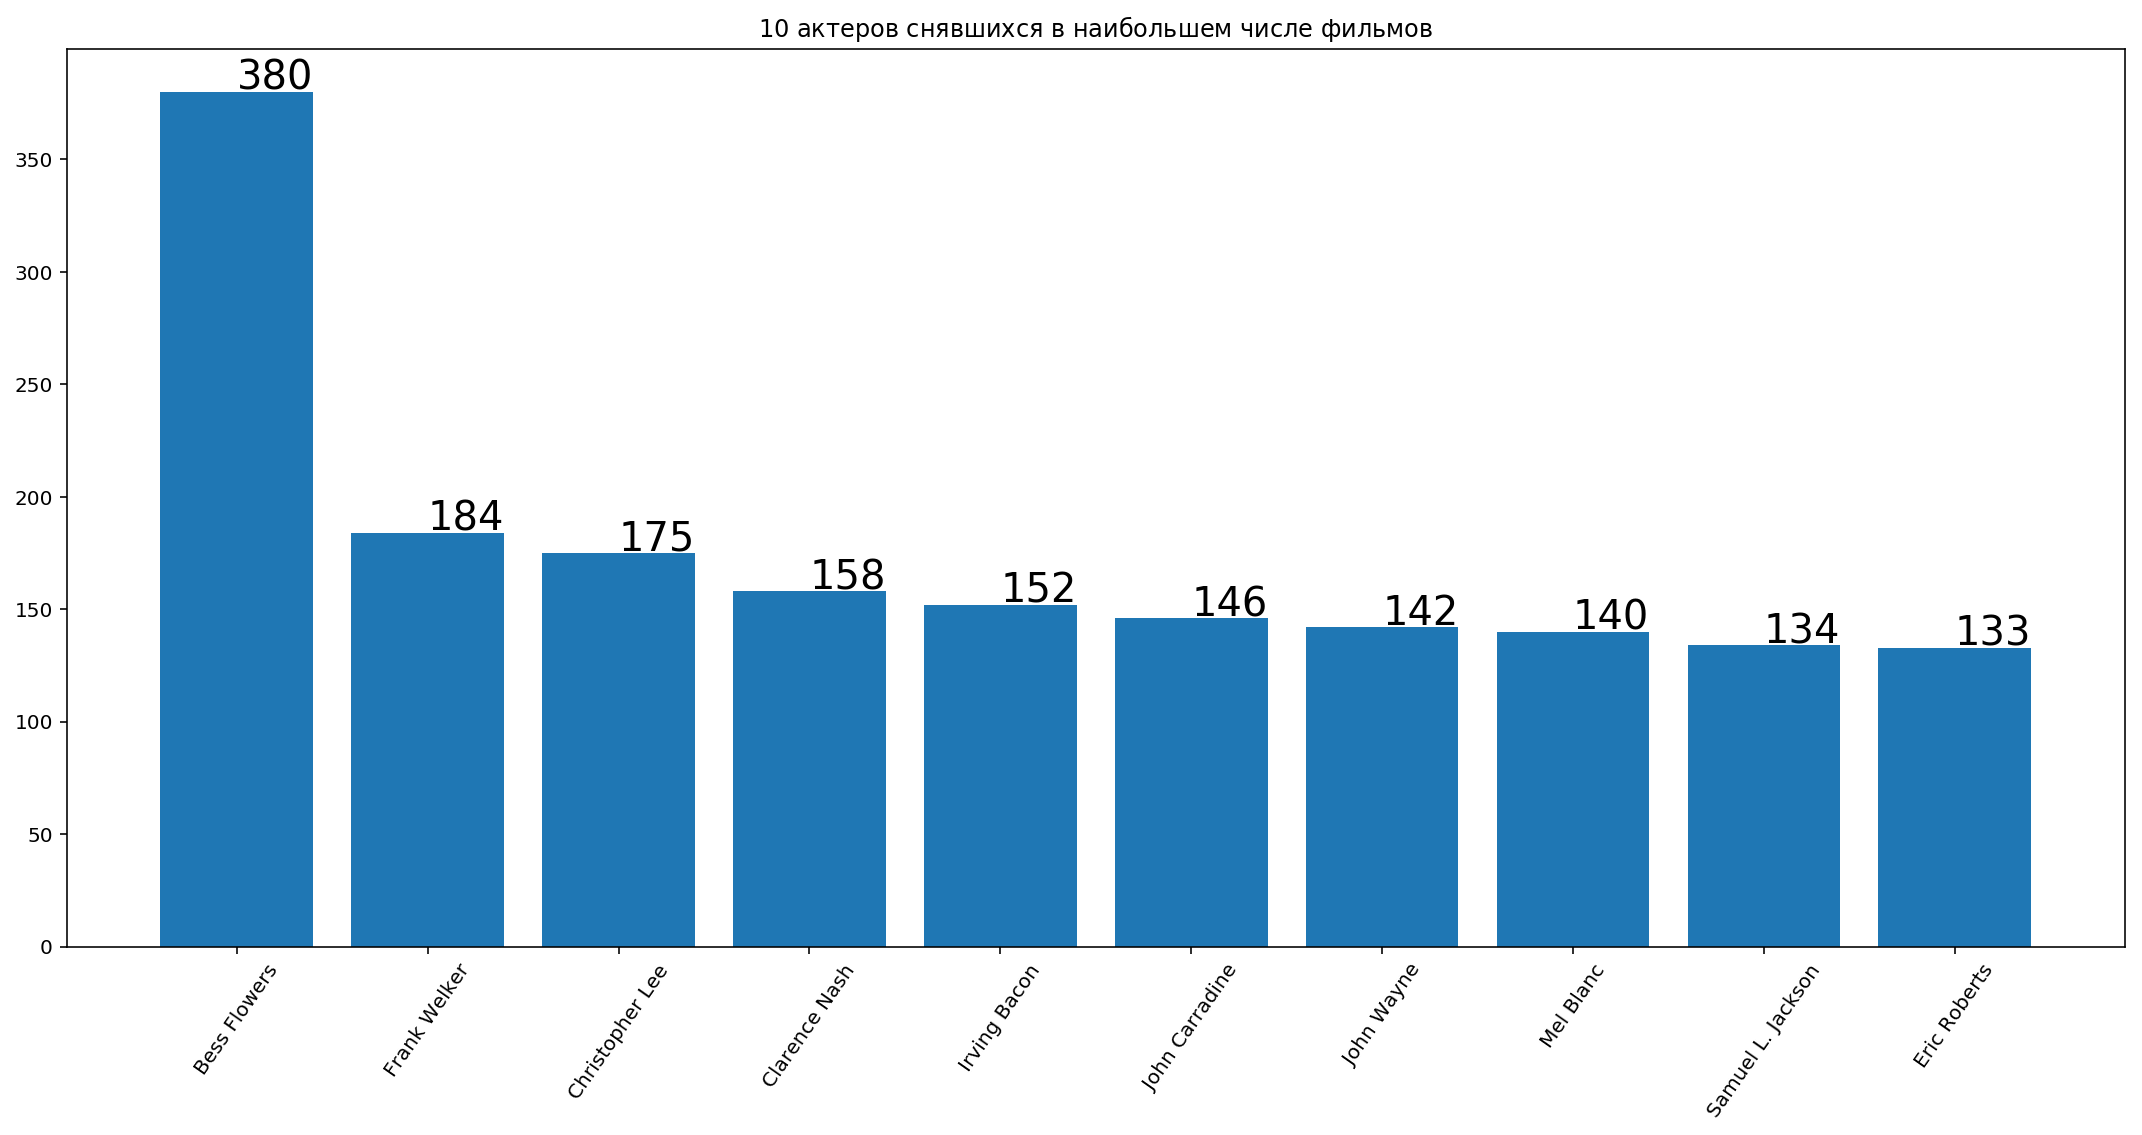

In [76]:
keys, values = zip(*top10_actors)

f, ax = plt.subplots(figsize=(15, 8))
plt.xticks(rotation=55, fontsize=10)
plt.bar(keys, values, align="center")
plt.title('$10$ актеров снявшихся в наибольшем числе фильмов')
plt.tight_layout()
for i in range(len(keys)):
    plt.text(x=keys[i], y=values[i]+1, s=values[i], fontdict=dict(fontsize=20))
plt.show()

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [49]:
import numpy as np

In [81]:
movieid_vs_year = tmdb \
    .filter(lambda temp: "id" in temp and temp["release_date"]) \
    .map(lambda temp: (temp["id"], int(temp["release_date"][:4]))) \
    .join(tmdb_to_id) \
    .map(lambda temp: (temp[1][1], temp[1][0]))

In [82]:
movieid_vs_year.take(5)

[(100595, 2011), (51933, 2007), (147308, 2008), (174261, 1909), (8921, 1955)]

In [83]:
movieid_vs_genre = sc.textFile(MOVIES_PATH) \
    .map(lambda s: s.split(',')) \
    .map(lambda s: (s[0], s[-1])) \
    .filter(lambda s: s[1] and s[1] != 'genres' and s[1] != '(no genres listed)') \
    .flatMap(lambda s: [(int(s[0]), genre) for genre in s[1].split("|")]) 

movieid_vs_genre.take(5)

[(1, 'Adventure'),
 (1, 'Animation'),
 (1, 'Children'),
 (1, 'Comedy'),
 (1, 'Fantasy')]

In [84]:
movieid_vs_genre \
    .join(movieid_vs_year) \
    .take(3)

[(196609, ('Comedy', 2015)),
 (196609, ('Horror', 2015)),
 (180229, ('Comedy', 1972))]

In [85]:
movieid_vs_genre \
    .join(movieid_vs_year) \
    .map(lambda s: ((s[1][0], s[1][1]), 1)) \
    .reduceByKey(lambda a, b : a + b) \
    .take(3)

[(('Action', 1982), 58), (('Crime', 1936), 27), (('IMAX', 2005), 5)]

In [86]:
movieid_vs_genre \
    .join(movieid_vs_year) \
    .map(lambda s: ((s[1][0], s[1][1]), 1)) \
    .reduceByKey(lambda a, b : a + b) \
    .map(lambda s: (s[0][1], (s[0][0], s[1]))) \
    .take(3)

[(1982, ('Action', 58)), (1936, ('Crime', 27)), (2005, ('IMAX', 5))]

In [87]:
# Не знаю какую брать границу снизу

data_by_year = movieid_vs_genre \
    .join(movieid_vs_year) \
    .map(lambda s: ((s[1][0], s[1][1]), 1)) \
    .reduceByKey(lambda a, b : a + b) \
    .map(lambda s: (s[0][1], (s[0][0], s[1]))) \
    .groupByKey() \
    .map(lambda s: (s[0], {genre : count for genre, count in s[1]})) \
    .sortByKey() \
    .filter(lambda temp: 1970 <= temp[0] <= 2019) \
    .collect()

In [88]:
genres = movieid_vs_genre \
    .map(lambda temp: temp[1]) \
    .distinct() \
    .sortBy(lambda x: x) \
    .collect()

In [89]:
genres

['Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [90]:
def get_ratios(genres, count_in_year):   
    ratios = np.array([count_in_year[genre] if genre in count_in_year else 0 for genre in genres])
        
    return ratios / ratios.sum()

In [91]:
years = np.array([year for year, _ in data_by_year])
ratios = np.stack([get_ratios(genres, count_in_year) for _, count_in_year in data_by_year]).T

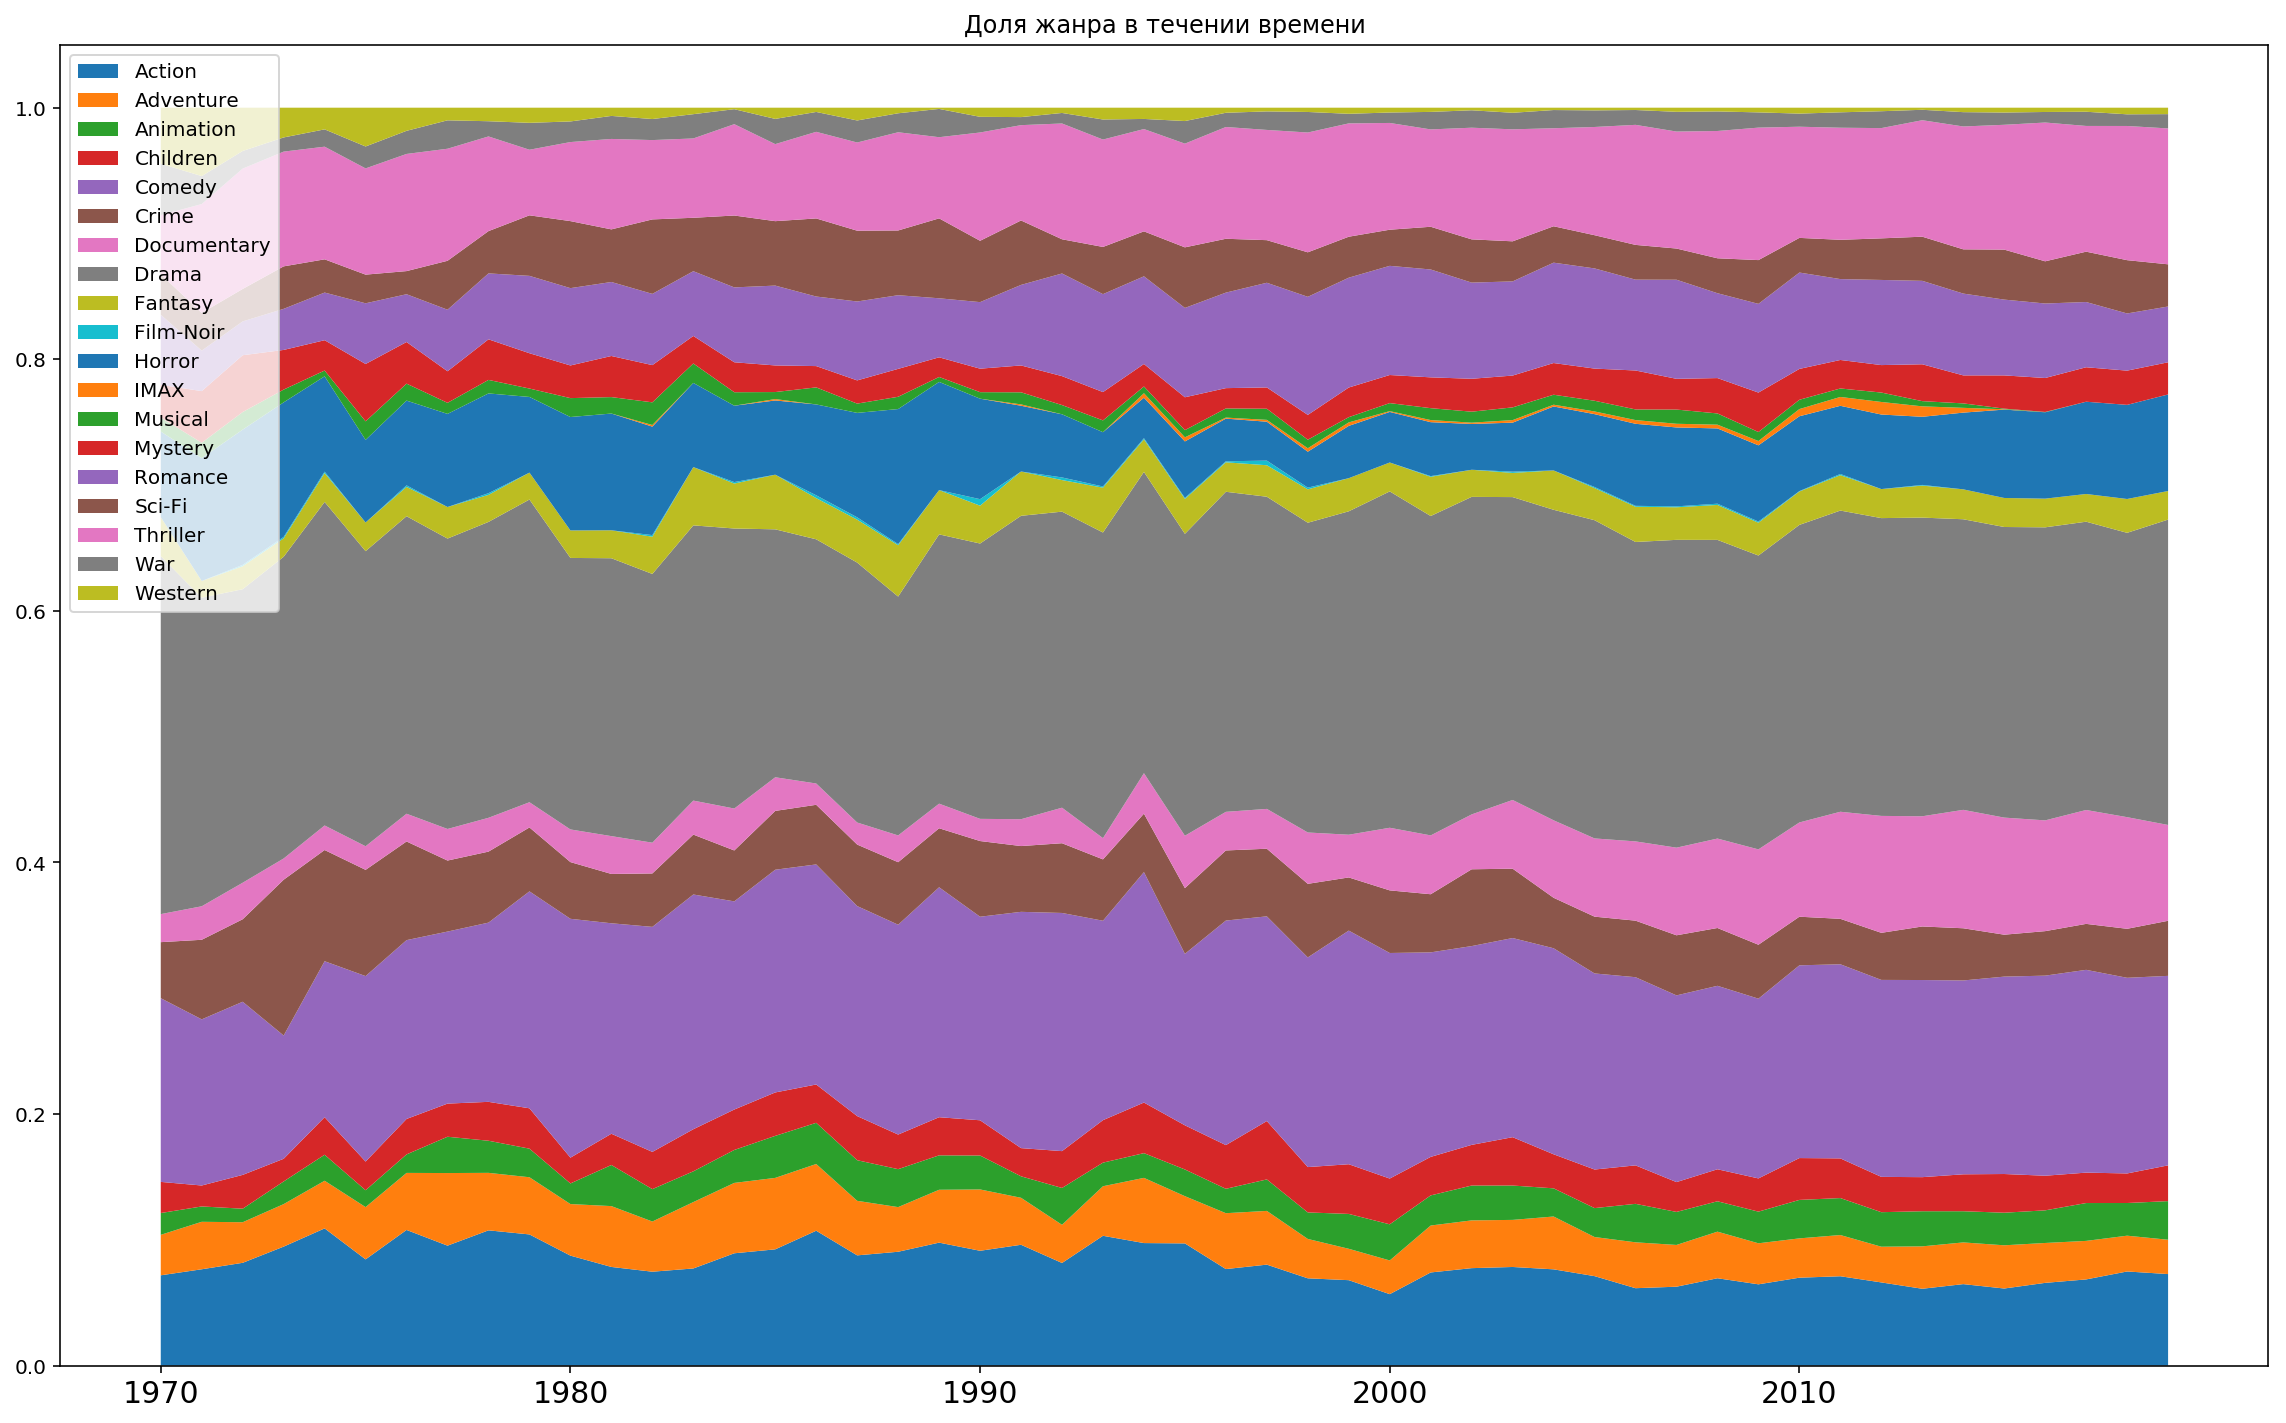

In [92]:
f, ax = plt.subplots(figsize=(16, 10))

ax.stackplot(years, ratios, labels=genres)
ax.legend(loc='upper left')
plt.xticks(years[::10], fontsize=15)
plt.title('Доля жанра в течении времени')
plt.tight_layout()
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [65]:
tmdb \
    .filter(lambda s: "id" in s) \
    .map(lambda s: (s["id"], (int(s["revenue"]), int(s["budget"])))) \
    .filter(lambda s: s[1][0] != 0 and s[1][1] != 0) \
    .join(tmdb_to_id) \
    .take(5)

[(5, ((4257354, 4000000), 18)),
 (15, ((23217674, 839727), 923)),
 (25, ((96889998, 72000000), 40278)),
 (35, ((527068851, 75000000), 54272)),
 (426030, ((15500000, 7154497), 184741))]

In [67]:
data_1 = tmdb \
    .filter(lambda s: "id" in s) \
    .map(lambda s: (s["id"], (int(s["revenue"]), int(s["budget"])))) \
    .filter(lambda s: s[1][0] != 0 and s[1][1] != 0) \
    .join(tmdb_to_id) \
    .map(lambda s: (s[1][1], (s[1][0][0], s[1][0][1])))

In [68]:
data_2 = movieid_vs_genre \
    .join(data_1)\
    .map(lambda s: (s[1][0], (s[1][1][0], s[1][1][1])))\
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
    .map(lambda s: (s[0], s[1][0] / s[1][1]))\
    .sortBy(lambda s: s[1], ascending=False)\
    .collect()

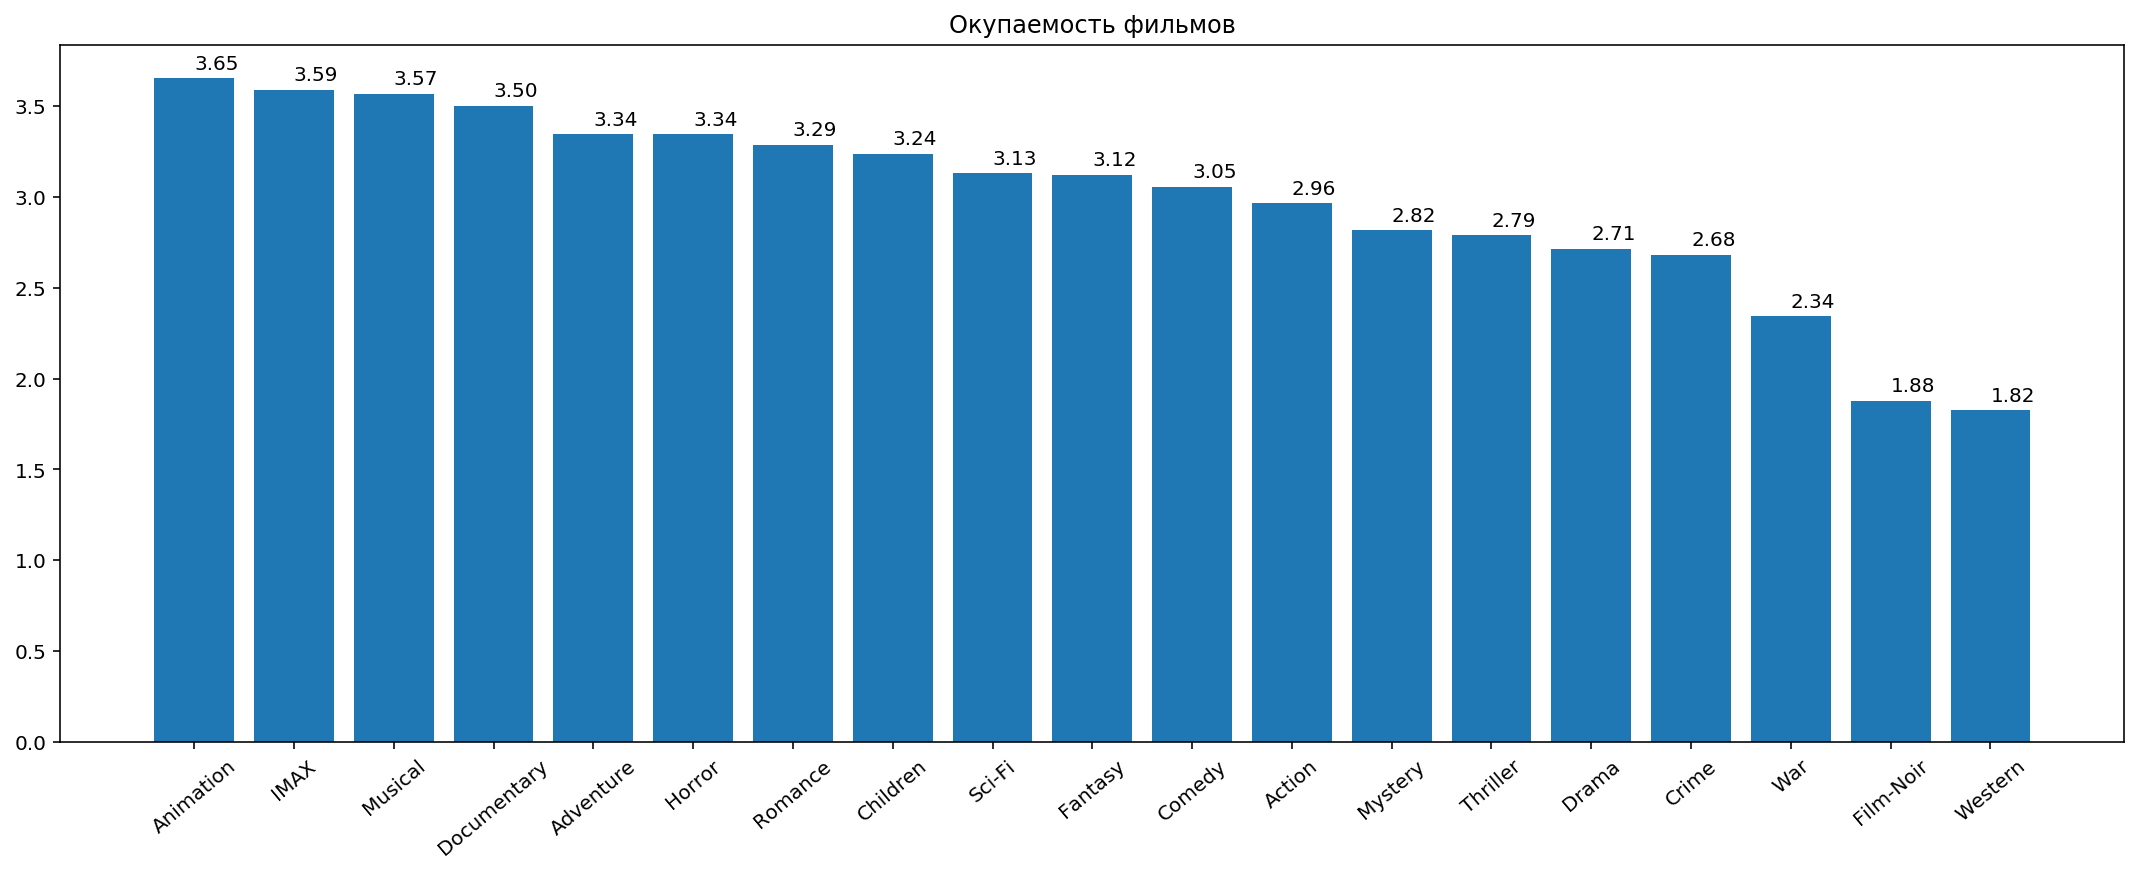

In [74]:
keys, values = zip(*data_2)

f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation=40, fontsize=10)
plt.bar(keys, values, align="center")
for i in range(len(keys)):
    plt.text(x=keys[i], y=values[i]+0.05, s="{:.2f}".format(values[i]), fontdict=dict(fontsize=10))
plt.tight_layout()
plt.title('Окупаемость фильмов')
plt.show()